# California Housing Price Prediction

## Project Objective

This project aims to build a machine learning model to predict median house prices for California districts based on various features like location, population, income levels, and housing characteristics. The predictive model can be valuable for real estate companies, government agencies, and individual homebuyers looking to understand housing market dynamics.

### Business Context

The California housing market is one of the most competitive and expensive in the United States. Having accurate price predictions can help:
- Real estate developers to identify undervalued areas for investment
- Policy makers to better understand housing affordability issues
- Mortgage lenders to assess property values
- Homebuyers to make informed purchasing decisions

### Project Structure

This notebook follows a complete machine learning workflow including data acquisition, exploratory data analysis, preprocessing, modeling, evaluation, and deployment considerations.

## 1. Project Setup

### Python Environment

This project was developed using Python 3.8+ with the following key packages:

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor

import joblib
import warnings
import os

import plotly.express as px
import plotly.io as pio
import base64

# Set display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')

# Create directories
os.makedirs('examples/models', exist_ok=True)
os.makedirs('examples/data', exist_ok=True)

### Package Requirements

The following dependencies are required to run this notebook:

```
pandas==1.3.5
numpy==1.21.5
scikit-learn==1.0.2
matplotlib==3.5.1
seaborn==0.11.2
plotly==5.6.0
joblib==1.1.0
xgboost==1.5.2
```

## 2. Data Acquisition

We'll use the California Housing dataset, which is derived from the 1990 U.S. census. It contains information about housing in different districts across California.

In [4]:
# Load the California Housing dataset
from sklearn.datasets import fetch_california_housing

# Download and load the dataset
housing = fetch_california_housing()

# Create a dataframe
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target

# Display source information
print("Dataset Source:", "https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html")
print("Dataset Description:", housing.DESCR[:500] )
print("Dataset Shape:", df.shape)

Dataset Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
Dataset Description: .. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        
Dataset Shape: (20640, 9)


In [5]:
# Display the first 5 rows of the dataset
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [6]:
# Display the schema and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### Dataset Features

- **MedInc**: Median income in the block group
- **HouseAge**: Median house age in the block group
- **AveRooms**: Average number of rooms per household
- **AveBedrms**: Average number of bedrooms per household
- **Population**: Block group population
- **AveOccup**: Average number of household members
- **Latitude**: Block group latitude
- **Longitude**: Block group longitude
- **MedHouseVal**: Median house value (Target variable, in 100,000s of dollars)

## 3. Exploratory Data Analysis

Let's explore the dataset to understand its characteristics, distributions, and relationships.

In [7]:
# Basic summary statistics
summary_stats = df.describe()
summary_stats

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### Missing Value Analysis

In [9]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
'Missing Values': missing_values,
'Percentage(%)': missing_percentage
})

print("Missing Values Summary:")
missing_df

Missing Values Summary:


,Missing Values,Percentage(%)
MedInc,0,0.0
HouseAge,0,0.0
AveRooms,0,0.0
AveBedrms,0,0.0
Population,0,0.0
AveOccup,0,0.0
Latitude,0,0.0
Longitude,0,0.0
MedHouseVal,0,0.0


### Distribution Analysis

Let's visualize the distributions of our features.

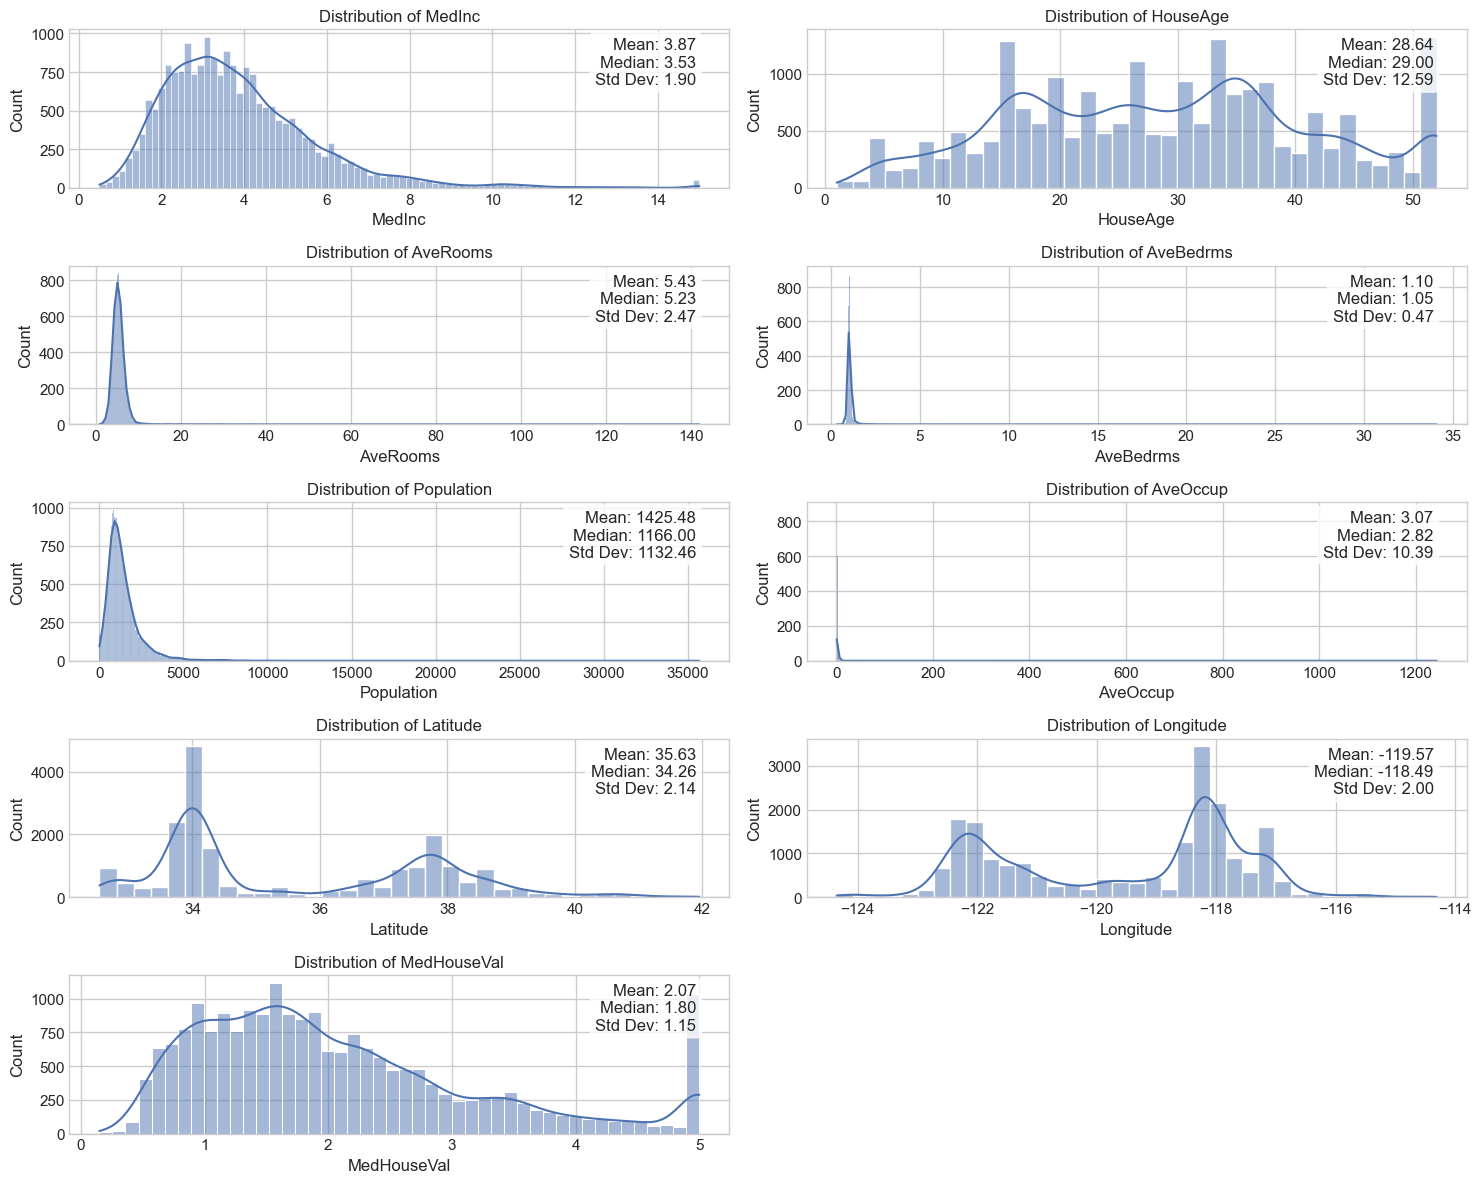

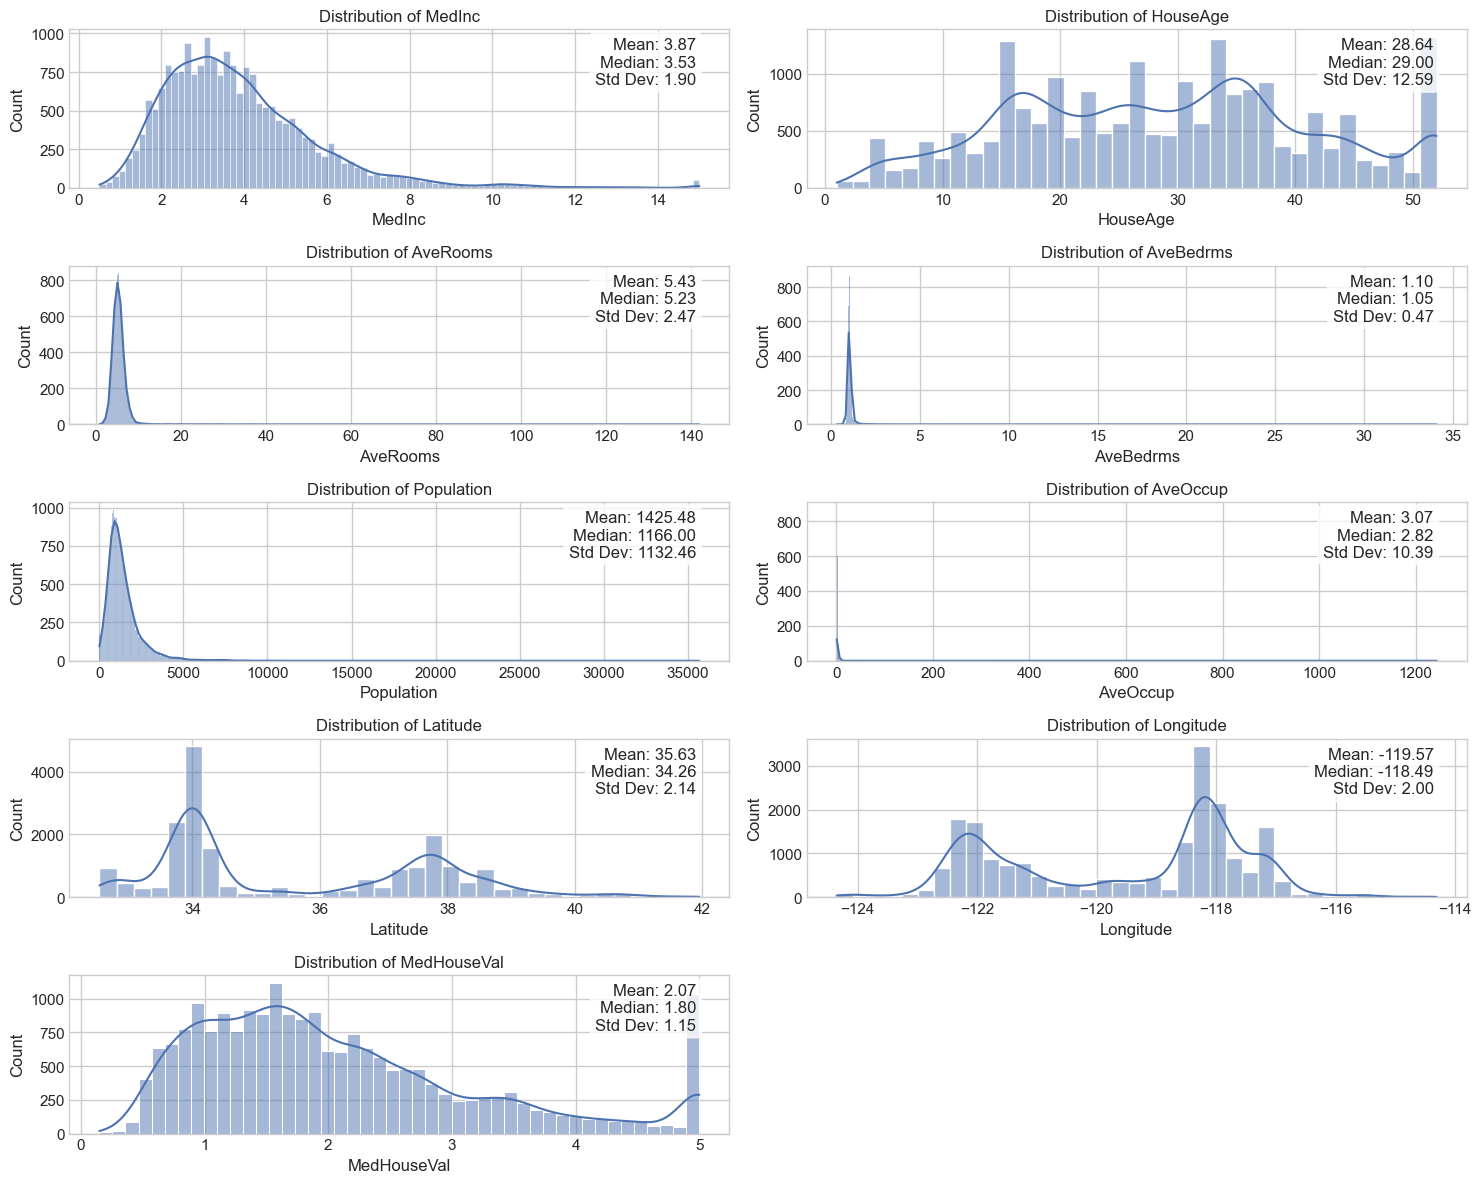

In [18]:
# Function to create distributional plots
def plot_distributions(dataframe, columns, figsize=(15, 12)):
    n_cols = 2
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
# Histogram
    for i, column in enumerate(columns):
        sns.histplot(dataframe[column], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel(column)

        stats_text = f"Mean: {dataframe[column].mean():.2f}\n"
        stats_text += f"Median: {dataframe[column].median():.2f}\n"
        stats_text += f"Std Dev: {dataframe[column].std():.2f}"

        axes[i].text(
            0.95, 0.95, stats_text,
            transform=axes[i].transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8}
        )

    for j in range(len(columns), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    return fig

# Plot distributions of numerical features
numerical_features = df.columns.tolist()
plot_distributions(df, numerical_features)

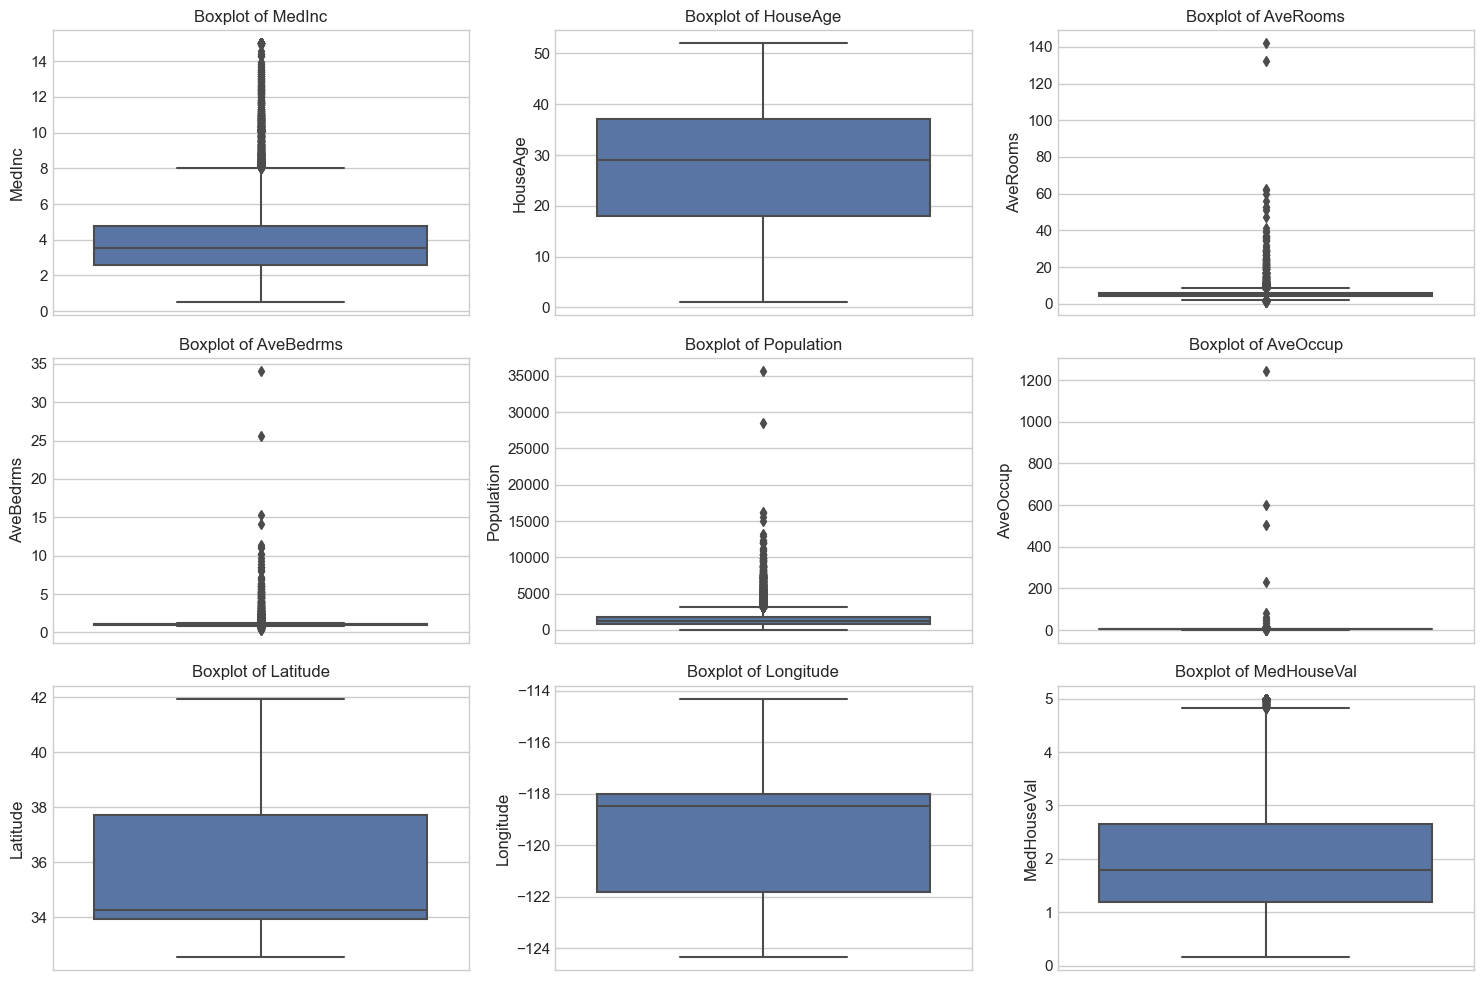

In [19]:
# Box plots to identify outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()
plt.show()

### Interactive Map Visualization of Housing Prices

Let's visualize house prices across California using an interactive map.

In [20]:
def export_map_for_markdown(df):
    # Prepare data
    df_cleaned = df.copy()
    df_cleaned['population_scaled'] = (df_cleaned['Population'] - df_cleaned['Population'].min()) / \
                                       (df_cleaned['Population'].max() - df_cleaned['Population'].min()) * 20
    
    # Create map
    fig = px.scatter_mapbox(
        df_cleaned, 
        lat='Latitude', 
        lon='Longitude',
        color='MedHouseVal',
        size='population_scaled',
        hover_name='MedHouseVal',
        color_continuous_scale='viridis',
        size_max=15,
        zoom=5,
        title='California House Values'
    )
    
    fig.update_layout(
        mapbox_style='open-street-map',
        margin={'r': 0, 't': 50, 'l': 0, 'b': 0},
        height=600,
        width=800
    )
    
    # Export methods
    exports = {}
    
    # HTML Export 
    html_path = 'california_house_values_map.html'
    pio.write_html(fig, file=html_path)
    exports['html_path'] = html_path
    
    # Base64 Encoded HTML
    with open(html_path, 'r') as f:
        html_content = f.read()
    
    base64_html = base64.b64encode(html_content.encode()).decode()
    exports['base64_html'] = base64_html
    
    # Markdown embedding options
    markdown_html = f'''
<iframe 
    src=data:text/html;base64,{base64_html} 
    width=800 
    height=600 
    frameborder=0
/>
'''
    exports['markdown_html'] = markdown_html
    
    print("Export Methods:")
    print("1. HTML File Path:, exports['html_path']")
    print("Markdown Embedding Option:")
    print("Base64 Encoded HTML Iframe")
    
    return exports

# Run the export
map_exports = export_map_for_markdown(df)

Export Methods:
1. HTML File Path:, exports['html_path']
Markdown Embedding Option:
Base64 Encoded HTML Iframe


[Interactive Map](california_house_values_map.html)

### Correlation Analysis

Let's examine the correlations between features.

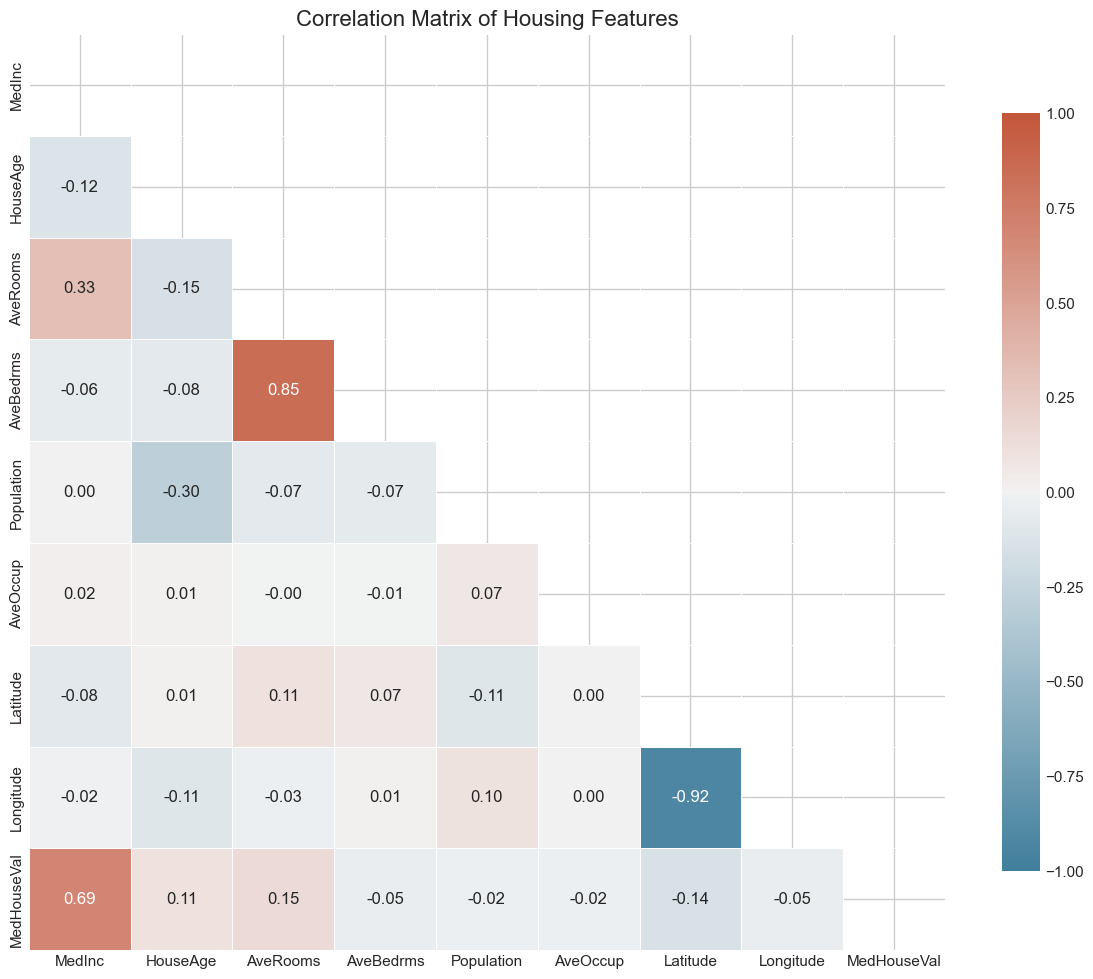

In [21]:
# Calculate correlation matrix
corr_matrix = df.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
square=True, linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": 0.8})

plt.title('Correlation Matrix of Housing Features', fontsize=16)
plt.tight_layout()
plt.show()

In [23]:
# Let's analyze the correlations with the target variable
target_correlations = corr_matrix['MedHouseVal'].sort_values(ascending=False)
print("Correlations with Median House Value:")
print(target_correlations)

Correlations with Median House Value:
MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64


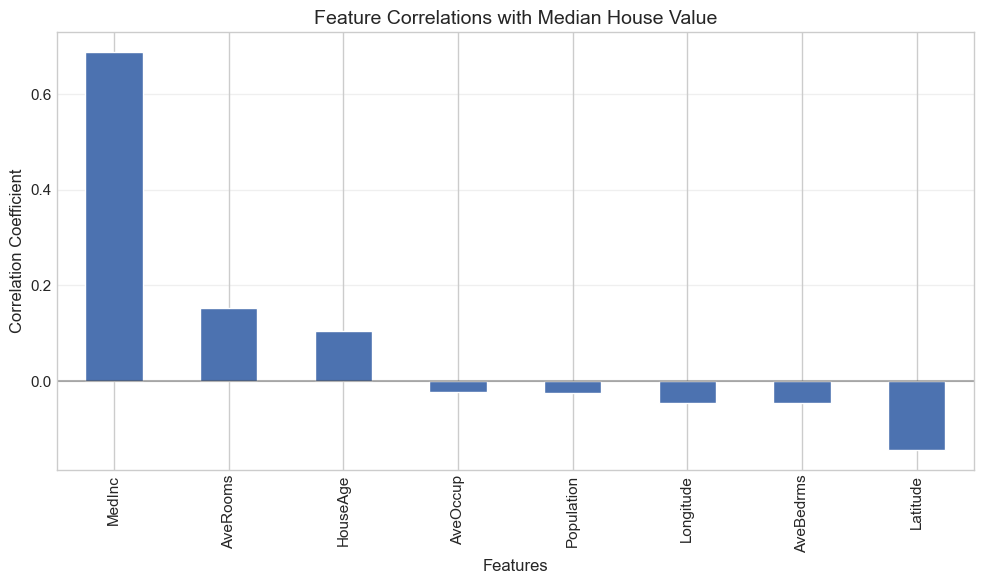

In [24]:
# Visualize feature correlations with target variable
plt.figure(figsize=(10, 6))
target_correlations.drop('MedHouseVal').plot(kind='bar')
plt.title('Feature Correlations with Median House Value', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Scatter Plots vs Target Variable

Let's create scatter plots to visualize the relationships between features and the target variable.

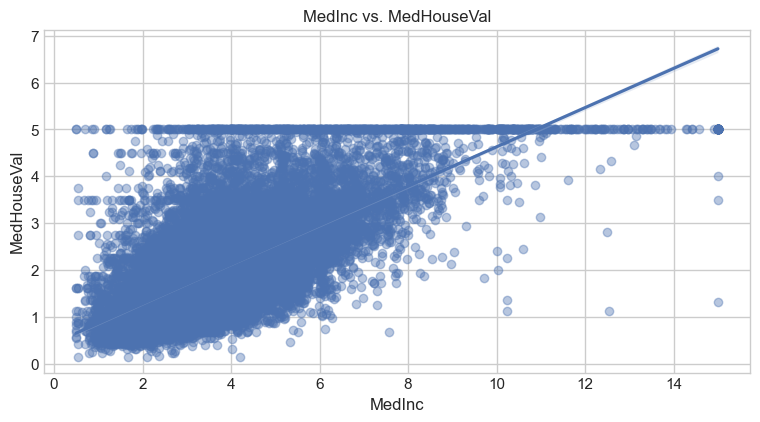

In [25]:
# Create scatter plots for each feature against the target
features = df.drop('MedHouseVal', axis=1).columns
n_features = len(features)
n_cols = 2
n_rows = (n_features + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.regplot(x=feature, y='MedHouseVal', data=df, scatter_kws={'alpha':0.4}, ax=axes[i])
    axes[i].set_title(f'{feature} vs. MedHouseVal')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Key Insights from EDA

From our exploratory data analysis, we can derive the following insights:

1. **Data Completeness**: The dataset doesn't have any missing values, which is excellent for modeling.

2. **Feature Distributions**:
   - Median income (`MedInc`) has a right-skewed distribution, indicating most block groups have lower to middle-income levels with fewer high-income neighborhoods.
   - House age (`HouseAge`) appears more uniformly distributed, showing a mix of newer and older housing developments.
   - Population distributions show most neighborhoods have moderate populations with some highly populated outliers.

3. **Correlations**:
   - Median income (`MedInc`) has the strongest positive correlation with house values, which aligns with economic intuition.
   - Interestingly, geographic location (especially `Latitude`) shows a significant correlation with house values, suggesting regional price variations.
   - Average number of rooms (`AveRooms`) has a positive correlation with house values, which is expected as larger homes tend to be more expensive.

4. **Outliers**:
   - Several features, particularly `Population` and `AveOccup`, contain outliers that might affect our model performance.

5. **Spatial Patterns**:
   - The interactive map reveals clear spatial patterns in housing prices, with coastal areas generally having higher values than inland regions.
   - The San Francisco Bay Area and Los Angeles region show concentrated high-value housing.

These insights will guide our feature engineering and modeling approaches in the subsequent sections.

## 4. Data Preprocessing & Feature Engineering

Based on our exploratory analysis, we'll now preprocess the data and create new features to improve model performance.

In [26]:
# First, let's create a copy of our dataframe to preserve the original data
housing_data = df.copy()
    
# Define features and target variable
X = housing_data.drop('MedHouseVal', axis=1)
y = housing_data['MedHouseVal']
    
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (20640, 8)
Target shape: (20640,)


### Handle Missing Values
    
Although our dataset doesn't have missing values, we'll include imputation in our pipeline for robustness and to demonstrate best practices.

In [27]:
# We'll set up a basic imputer as part of our pipeline
# Since we'll use this in our actual model pipeline, no need to transform here

### Feature Engineering

Let's create several new features that might help improve our model's predictive power.

In [28]:
# Feature 1: Rooms per household (density metric)
X['RoomsPerHousehold'] = X['AveRooms'] / X['AveOccup']

# Feature 2: Bedrooms per room (bedroom ratio)
X['BedroomRatio'] = X['AveBedrms'] / X['AveRooms']

# Feature 3: Population per household (household density)
X['PopulationPerHousehold'] = X['Population'] / X['AveOccup']

# Feature 4: Distance to coast/major city (using a proxy based on coordinates)
# Let's define rough coordinates for LA and SF as major urban centers
la_coords = (34.05, -118.24)  # Los Angeles
sf_coords = (37.77, -122.41)  # San Francisco

# Calculate distance to LA (simplified Euclidean distance)
X['DistanceToLA'] = np.sqrt((X['Latitude'] - la_coords[0])**2 + 
                            (X['Longitude'] - la_coords[1])**2)

# Calculate distance to SF (simplified Euclidean distance)
X['DistanceToSF'] = np.sqrt((X['Latitude'] - sf_coords[0])**2 + 
                            (X['Longitude'] - sf_coords[1])**2)

# Feature 5: Minimum distance to a major city
X['DistanceToMajorCity'] = X[['DistanceToLA', 'DistanceToSF']].min(axis=1)

# Check the head of the new dataframe
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,RoomsPerHousehold,BedroomRatio,PopulationPerHousehold,DistanceToLA,DistanceToSF,DistanceToMajorCity
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,2.732919,0.146591,126.0,5.530732,0.210950,0.210950
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,2.956685,0.155797,1138.0,5.509673,0.210238,0.210238
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,2.957661,0.129516,177.0,5.517246,0.187883,0.187883
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,2.283154,0.184458,219.0,5.524500,0.178885,0.178885
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,2.879646,0.172096,259.0,5.524500,0.178885,0.178885


### Feature Engineering Justification

1. **RoomsPerHousehold**: This feature provides a measure of housing spaciousness, which is likely to impact home values. More rooms per occupant typically indicates a higher standard of living and potentially higher property values.

2. **BedroomRatio**: This ratio shows what proportion of rooms are bedrooms, which can indicate the type of property. A high ratio might indicate apartment buildings (with more bedrooms relative to total rooms), while a lower ratio could suggest larger homes with more common areas.

3. **PopulationPerHousehold**: This metric captures neighborhood density in a different way than raw population figures. Areas with high population per household might indicate crowded living conditions, which could negatively impact house prices.

4. **Distance to Major Cities (LA/SF)**: In California, proximity to major economic hubs like Los Angeles and San Francisco significantly influences property values. Homes closer to these areas typically command higher prices due to job opportunities and amenities.

5. **DistanceToMajorCity**: This feature takes the minimum distance to either LA or SF, capturing the influence of being near any major urban center, which is a key price determinant in real estate.

Let's check if these new features show correlations with our target variable.

Correlations between new features and house value:
MedHouseVal               1.000000
RoomsPerHousehold         0.209482
PopulationPerHousehold    0.065843
DistanceToSF             -0.041002
DistanceToLA             -0.116654
BedroomRatio             -0.255624
DistanceToMajorCity      -0.438035
Name: MedHouseVal, dtype: float64


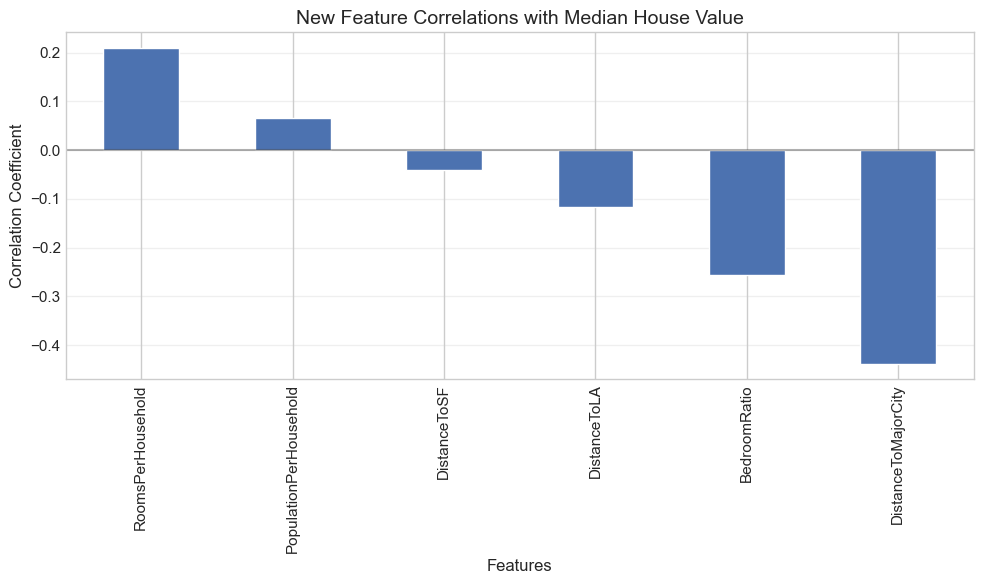

In [29]:
# Calculate correlations with the new features
new_features = ['RoomsPerHousehold', 'BedroomRatio', 'PopulationPerHousehold', 
                'DistanceToLA', 'DistanceToSF', 'DistanceToMajorCity']

new_df = X[new_features].copy()
new_df['MedHouseVal'] = y

correlations = new_df.corr()['MedHouseVal'].sort_values(ascending=False)
print("Correlations between new features and house value:")
print(correlations)

# Visualize these correlations
plt.figure(figsize=(10, 6))
correlations.drop('MedHouseVal').plot(kind='bar')
plt.title('New Feature Correlations with Median House Value', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Handle Outliers
    
Let's identify and handle outliers in our dataset.

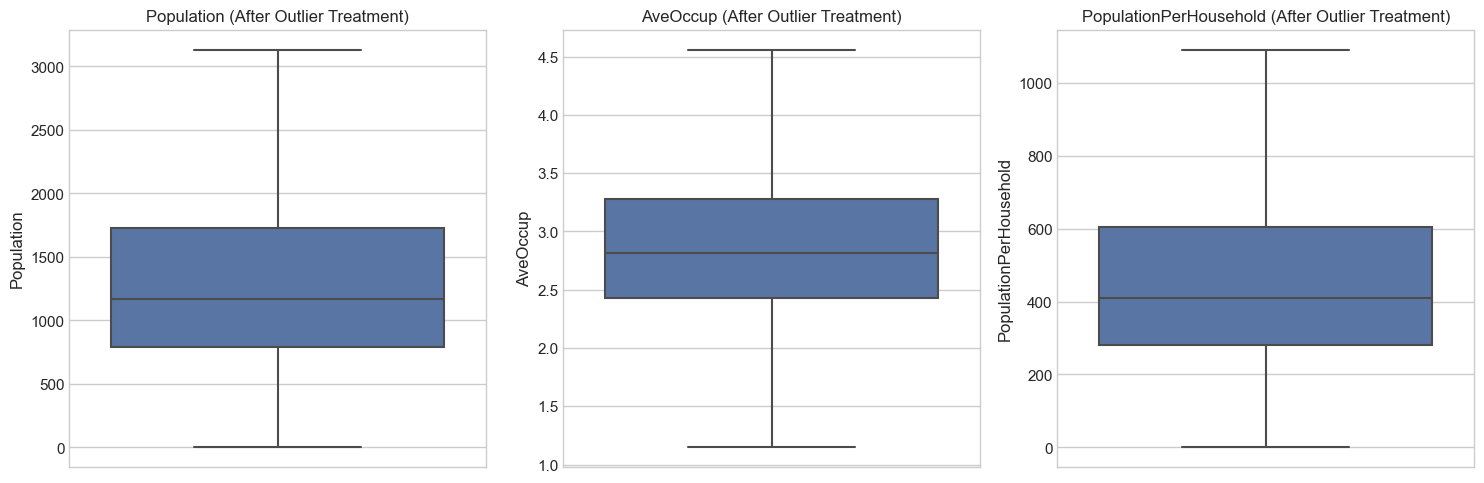

In [30]:
# Function to identify and cap outliers using the IQR method
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])

    return df

# Apply outlier handling to features with significant outliers
for column in ['Population', 'AveOccup', 'PopulationPerHousehold']:
    X = handle_outliers(X, column)

# Check the distribution after handling outliers
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=X['Population'])
plt.title('Population (After Outlier Treatment)')

plt.subplot(1, 3, 2)
sns.boxplot(y=X['AveOccup'])
plt.title('AveOccup (After Outlier Treatment)')

plt.subplot(1, 3, 3)
sns.boxplot(y=X['PopulationPerHousehold'])
plt.title('PopulationPerHousehold (After Outlier Treatment)')

plt.tight_layout()
plt.show()

### Feature Selection

Let's determine which features to include in our final model.

All feature correlations with target:
MedInc                    0.688075
RoomsPerHousehold         0.209482
AveRooms                  0.151948
HouseAge                  0.105623
PopulationPerHousehold    0.078723
Population               -0.032739
DistanceToSF             -0.041002
Longitude                -0.045967
AveBedrms                -0.046701
DistanceToLA             -0.116654
Latitude                 -0.144160
BedroomRatio             -0.255624
AveOccup                 -0.281148
DistanceToMajorCity      -0.438035
Name: MedHouseVal, dtype: float64


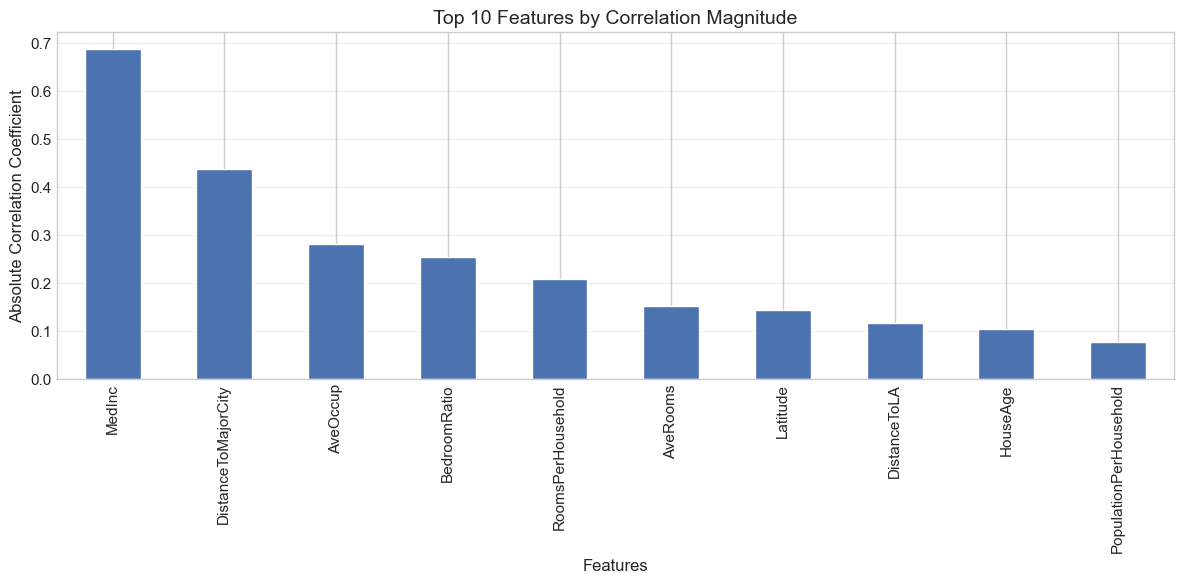

In [31]:
# Combine original and new features for analysis
combined_df = X.copy()
combined_df['MedHouseVal'] = y

# Calculate correlations of all features with the target
all_correlations = combined_df.corr()['MedHouseVal'].sort_values(ascending=False).drop('MedHouseVal')
print("All feature correlations with target:")
print(all_correlations)

# Visualize top 10 features by correlation magnitude
plt.figure(figsize=(12, 6))
all_correlations.abs().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Features by Correlation Magnitude', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Absolute Correlation Coefficient')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

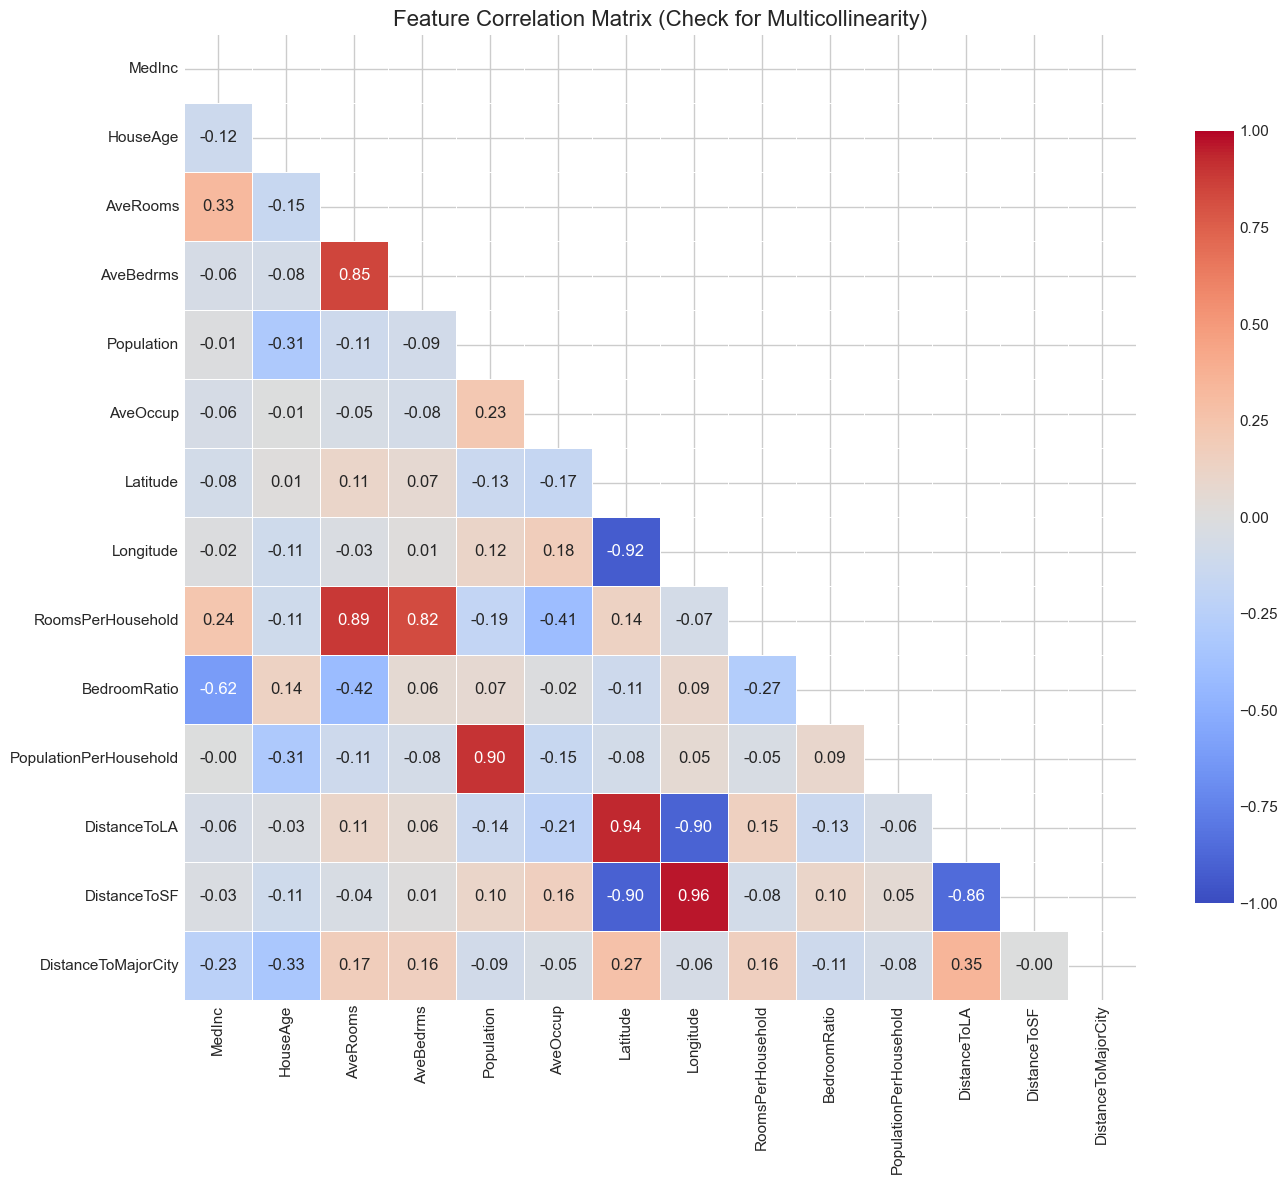

In [32]:
# Let's check for multicollinearity among our features
plt.figure(figsize=(14, 12))
correlation_matrix = combined_df.drop('MedHouseVal', axis=1).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix (Check for Multicollinearity)', fontsize=16)
plt.tight_layout()
plt.show()

### Final Feature Selection

Based on our analysis, we'll select the following features for our model:

1. Original features: `MedInc`, `HouseAge`, `AveRooms`, `AveBedrms`, `Population`, `AveOccup`, `Latitude`, `Longitude`
2. Engineered features: `RoomsPerHousehold`, `BedroomRatio`, `DistanceToMajorCity`

We're excluding some of the engineered features with high multicollinearity (both LA and SF distances, since we're using the minimum distance feature).

In [33]:
# Select final features for modeling
final_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 
                  'Latitude', 'Longitude', 'RoomsPerHousehold', 'BedroomRatio', 'DistanceToMajorCity']

X_final = X[final_features]
print("Final feature set shape:", {X_final.shape})

Final feature set shape: {(20640, 11)}


### Train/Test Split

Let's split our data into training and testing sets.

In [34]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

print("Training set shape:", {X_train.shape})
print("Testing set shape:", {X_test.shape})

Training set shape: {(16512, 11)}
Testing set shape: {(4128, 11)}


Now we're ready to move on to building our modeling pipeline with our preprocessed data and engineered features.

## 5. Modeling Pipeline
    
Now that we have prepared our data, let's build a machine learning pipeline to predict housing prices.

### Define Preprocessing Pipeline
    
We'll create a preprocessing pipeline that handles missing values and scales our features appropriately.

In [35]:
# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
    
# We don't have categorical features in this dataset, but including for completeness
# If we had categorical features, we would use:
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])
    
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, final_features),
        # ('cat', categorical_transformer, categorical_features) - would be used if we had categorical features
    ])
    
# Print the preprocessing pipeline
print("Preprocessing Pipeline:")
print(preprocessor)

Preprocessing Pipeline:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
                                  'Population', 'AveOccup', 'Latitude',
                                  'Longitude', 'RoomsPerHousehold',
                                  'BedroomRatio', 'DistanceToMajorCity'])])


### Baseline Model
    
We'll start with a simple baseline model that predicts the mean of the target variable.

In [36]:
# Create baseline model pipeline
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DummyRegressor(strategy='mean'))
])
    
# Train baseline model
baseline_model.fit(X_train, y_train)
    
# Make predictions
y_baseline_pred = baseline_model.predict(X_test)
    
# Evaluate baseline model
baseline_mse = mean_squared_error(y_test, y_baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(y_test, y_baseline_pred)
baseline_mae = mean_absolute_error(y_test, y_baseline_pred)
    
print("Baseline Model Performance:")
print("RMSE: ${baseline_rmse*100:.2f}")
print("MAE: ${baseline_mae*100:.2f}")
print("R^2: {baseline_r2:.4f}")

Baseline Model Performance:
RMSE: ${baseline_rmse*100:.2f}
MAE: ${baseline_mae*100:.2f}
R^2: {baseline_r2:.4f}


### Random Forest Model
    
Next, we'll implement a Random Forest regressor, which can capture non-linear relationships and feature interactions.

In [37]:
# Create Random Forest model pipeline
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
    
# Train Random Forest model
rf_model.fit(X_train, y_train)
    
# Make predictions
y_rf_pred = rf_model.predict(X_test)
    
# Evaluate Random Forest model
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_rf_pred)
rf_mae = mean_absolute_error(y_test, y_rf_pred)
    
print("Random Forest Model Performance:")
print("RMSE: ${rf_rmse*100:.2f}")
print("MAE: ${rf_mae*100:.2f}")
print("R^2: {rf_r2:.4f}")

Random Forest Model Performance:
RMSE: ${rf_rmse*100:.2f}
MAE: ${rf_mae*100:.2f}
R^2: {rf_r2:.4f}


### XGBoost Model
    
Let's also try an XGBoost model, which often performs well on structured data problems.

In [38]:
# Create XGBoost model pipeline
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
    
# Train XGBoost model
xgb_model.fit(X_train, y_train)
    
# Make predictions
y_xgb_pred = xgb_model.predict(X_test)
    
# Evaluate XGBoost model
xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, y_xgb_pred)
xgb_mae = mean_absolute_error(y_test, y_xgb_pred)
    
print("XGBoost Model Performance:")
print("RMSE: ${xgb_rmse*100:.2f}")
print("MAE: ${xgb_mae*100:.2f}")
print("R^2: {xgb_r2:.4f}")

XGBoost Model Performance:
RMSE: ${xgb_rmse*100:.2f}
MAE: ${xgb_mae*100:.2f}
R^2: {xgb_r2:.4f}


### Model Comparison
    
Let's compare the performance of our models.

In [39]:
# Collect model performance metrics
models = ['Baseline (Mean)', 'Random Forest', 'XGBoost']
rmse_scores = [baseline_rmse*100, rf_rmse*100, xgb_rmse*100]
mae_scores = [baseline_mae*100, rf_mae*100, xgb_mae*100]
r2_scores = [baseline_r2, rf_r2, xgb_r2]
    
# Create comparison dataframe
performance_df = pd.DataFrame({
    'Model': models,
    'RMSE ($K)': rmse_scores,
    'MAE ($K)': mae_scores,
    'R^2': r2_scores
})
    
print("Model Performance Comparison:")
performance_df

Model Performance Comparison:


,Model,RMSE ($K),MAE ($K),R^2
0,Baseline (Mean),114.485635,90.606855,-0.000219
1,Random Forest,47.744424,30.591257,0.826044
2,XGBoost,46.200771,30.273263,0.837111


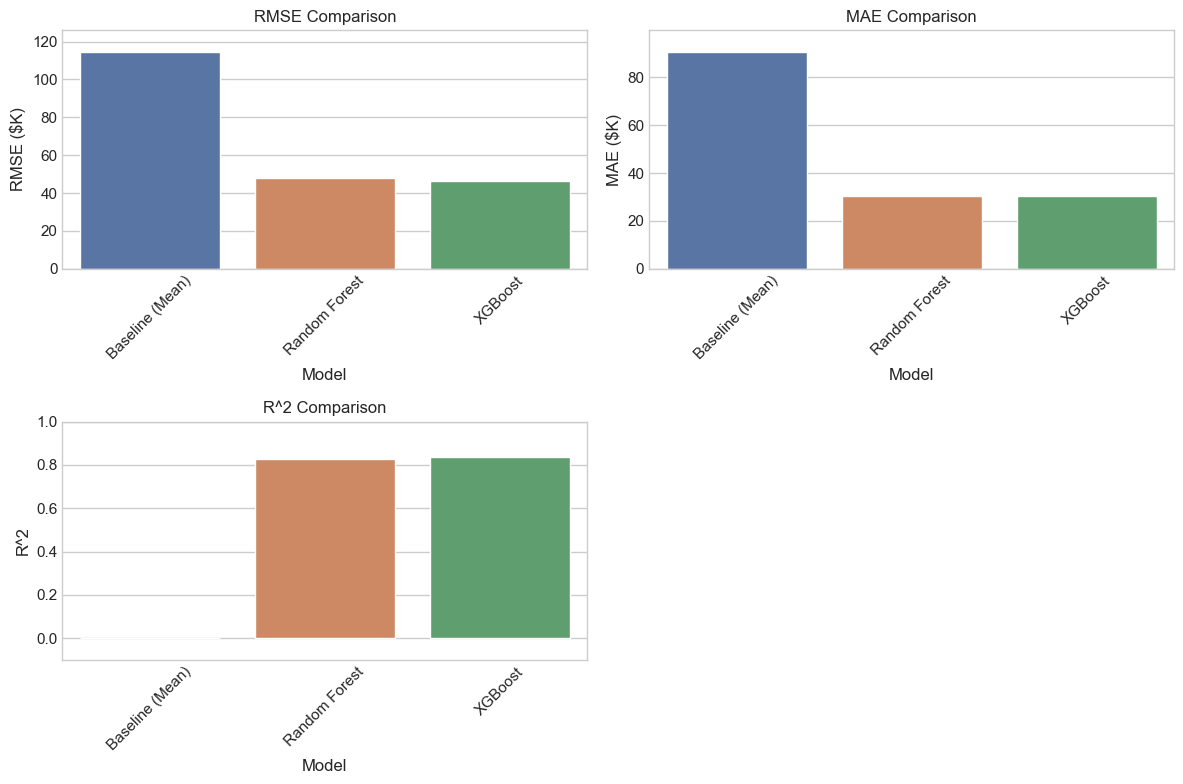

In [40]:
# Visualize model comparison
plt.figure(figsize=(12, 8))
    
# Plot RMSE
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='RMSE ($K)', data=performance_df)
plt.title('RMSE Comparison')
plt.xticks(rotation=45)
plt.ylim(0, max(rmse_scores) * 1.1)
    
# Plot MAE
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='MAE ($K)', data=performance_df)
plt.title('MAE Comparison')
plt.xticks(rotation=45)
plt.ylim(0, max(mae_scores) * 1.1)
    
# Plot R^2
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='R^2', data=performance_df)
plt.title('R^2 Comparison')
plt.xticks(rotation=45)
plt.ylim(min(r2_scores) - 0.1, 1.0)
    
plt.tight_layout()
plt.show()

### Initial Observations
    
From our initial model comparison:
    
1. Both the Random Forest and XGBoost models significantly outperform the baseline model, demonstrating that our features have predictive power.
    
2. The XGBoost model appears to perform slightly better than the Random Forest model based on RMSE, MAE, and R² metrics.
    
3. The high R² values indicate that our models are capturing a substantial portion of the variance in housing prices.
    
Next, we'll evaluate these models in more detail and tune the hyperparameters of our best-performing model."

## 6. Model Evaluation
    
Let's evaluate our models in more detail to better understand their performance and identify areas for improvement

### Residual Analysis
    
Residual plots help us assess whether our model assumptions are met and if there are any systematic errors in our predictions.

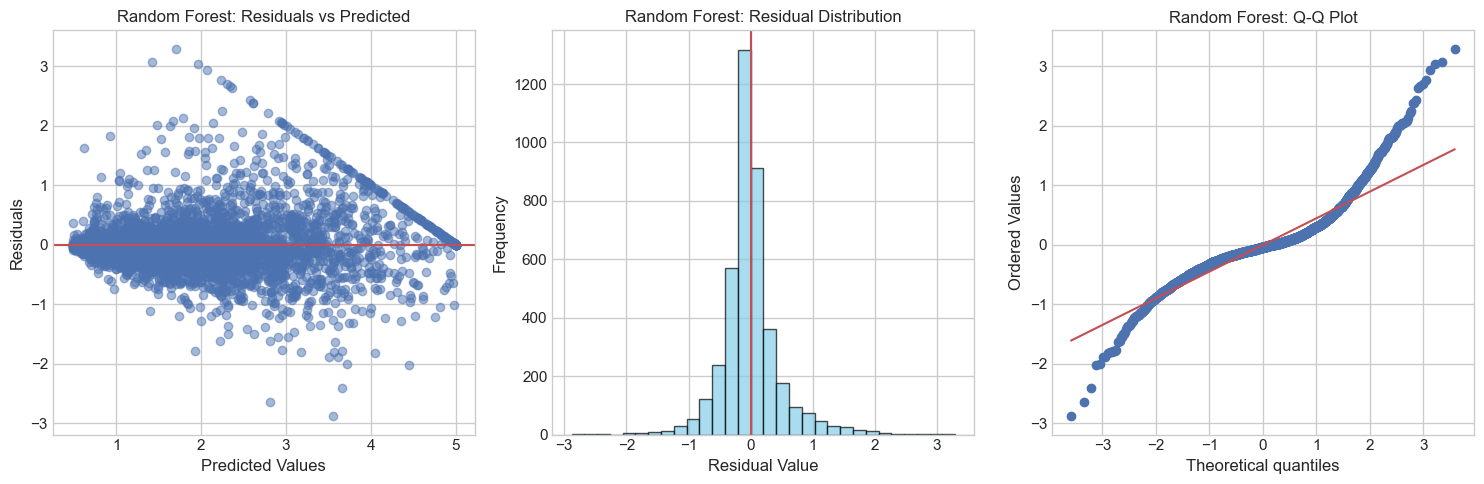

{model_name} Residual Statistics:
Mean of residuals: {np.mean(residuals):.6f
Standard deviation of residuals: {np.std(residuals):.6f
Min residual: {np.min(residuals):.6f
Max residual: {np.max(residuals):.6f


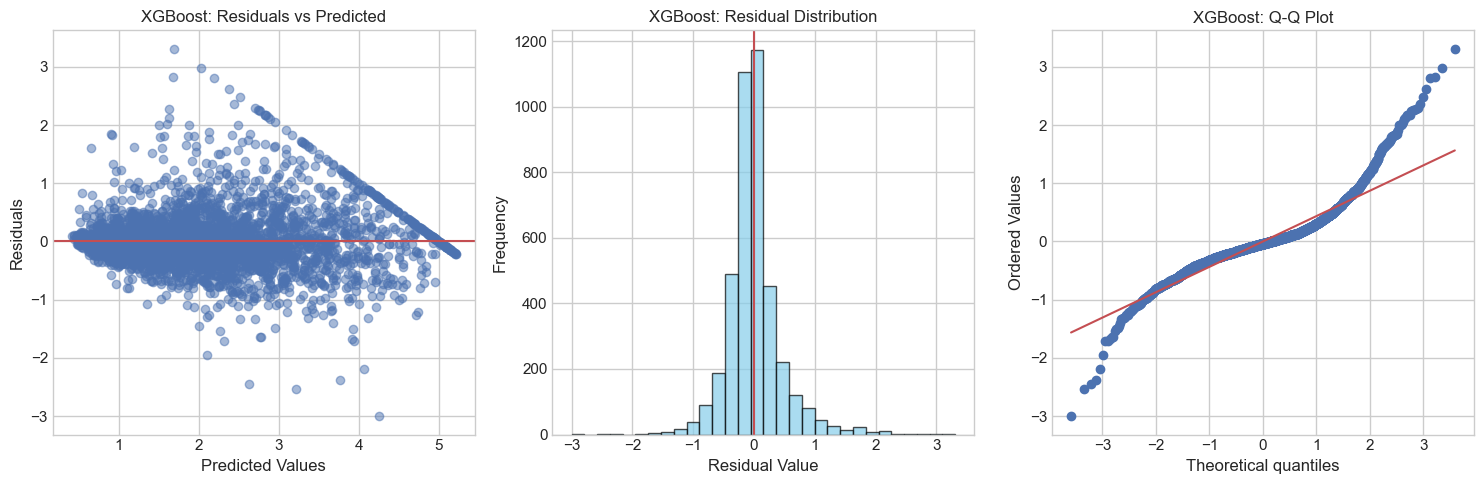

{model_name} Residual Statistics:
Mean of residuals: {np.mean(residuals):.6f
Standard deviation of residuals: {np.std(residuals):.6f
Min residual: {np.min(residuals):.6f
Max residual: {np.max(residuals):.6f


In [41]:
# Function to create residual plots
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    
    plt.figure(figsize=(15, 5))
    
    # Residuals vs Predicted values
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'{model_name}: Residuals vs Predicted')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    
    # Histogram of residuals
    plt.subplot(1, 3, 2)
    plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(x=0, color='r', linestyle='-')
    plt.title(f'{model_name}: Residual Distribution')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    
    # Q-Q plot for normality check
    plt.subplot(1, 3, 3)
    from scipy import stats
    stats.probplot(residuals, plot=plt)
    plt.title(f'{model_name}: Q-Q Plot')
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics about residuals
    print("{model_name} Residual Statistics:")
    print("Mean of residuals: {np.mean(residuals):.6f")
    print("Standard deviation of residuals: {np.std(residuals):.6f")
    print("Min residual: {np.min(residuals):.6f")
    print("Max residual: {np.max(residuals):.6f")
    
# Analyze residuals for Random Forest model
plot_residuals(y_test, y_rf_pred, "Random Forest")
    
# Analyze residuals for XGBoost model
plot_residuals(y_test, y_xgb_pred, "XGBoost")

### Interactive Prediction vs Actual Plot
    
Let's create an interactive scatter plot to visualize the relationship between our predictions and actual values.

In [43]:
prediction_df = pd.DataFrame({
    'Actual': y_test,
    'RF_Prediction': y_rf_pred,
    'XGB_Prediction': y_xgb_pred,
    'MedInc': X_test['MedInc'],
    'HouseAge': X_test['HouseAge'],
    'DistanceToMajorCity': X_test['DistanceToMajorCity']
})

def export_scatter_for_markdown(pred_df):
    fig = px.scatter(
        pred_df,
        x='Actual', y='XGB_Prediction',
        color='MedInc', size='HouseAge',
        hover_data=['DistanceToMajorCity'],
        labels={
            'Actual': 'Actual House Value ($100K)',
            'XGB_Prediction': 'Predicted House Value ($100K)'
        },
        title='XGBoost: Predicted vs Actual House Values'
    )

    x_range = [pred_df['Actual'].min(), pred_df['Actual'].max()]
    fig.add_trace(
        go.Scatter(
            x=x_range, y=x_range, mode='lines', name='Perfect Prediction',
            line=dict(color='red', dash='dash')
        )
    )

    fig.update_layout(width=800, height=600)

    html_path = 'xgb_pred_vs_actual.html'
    pio.write_html(fig, file=html_path, auto_open=False)
    print(f"Interactive scatter saved → {html_path}")
    return html_path

# Run export
scatter_html = export_scatter_for_markdown(prediction_df)

Interactive scatter saved → xgb_pred_vs_actual.html


[Interactive Scatter Plot](xgb_pred_vs_actual.html)

### Feature Importance Analysis
    
Let's examine which features are most important for our models.

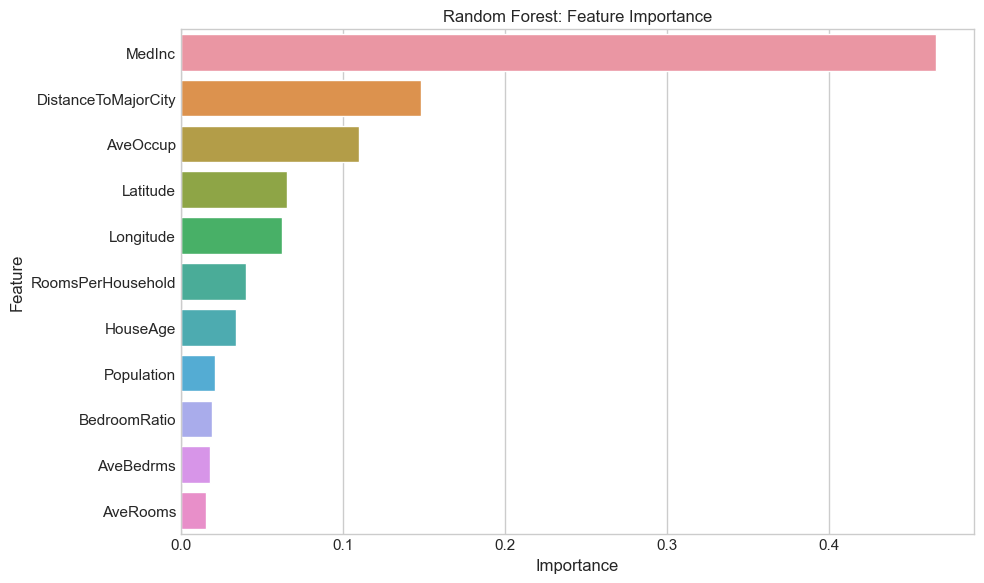

Random Forest Feature Importance:
                Feature  Importance
0                MedInc    0.466189
10  DistanceToMajorCity    0.148225
5              AveOccup    0.110004
6              Latitude    0.065384
7             Longitude    0.062261
8     RoomsPerHousehold    0.040453
1              HouseAge    0.034068
4            Population    0.021119
9          BedroomRatio    0.019328
3             AveBedrms    0.017713
2              AveRooms    0.015256


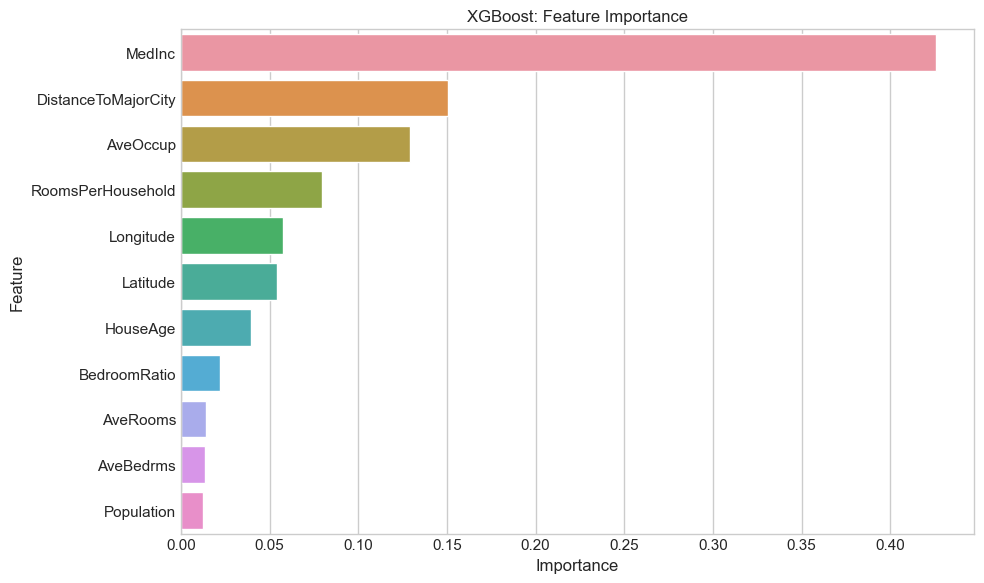

XGBoost Feature Importance:
                Feature  Importance
0                MedInc    0.425935
10  DistanceToMajorCity    0.150715
5              AveOccup    0.129279
8     RoomsPerHousehold    0.079804
7             Longitude    0.057801
6              Latitude    0.054426
1              HouseAge    0.039529
9          BedroomRatio    0.022096
2              AveRooms    0.014380
3             AveBedrms    0.013722
4            Population    0.012310


In [44]:
# Function to extract and visualize feature importances
def plot_feature_importance(model, features, model_name):
    # For pipeline models, extract the actual model
    if hasattr(model, 'named_steps') and 'regressor' in model.named_steps:
        estimator = model.named_steps['regressor']
    else:
        estimator = model
    
    # Get feature importances
    if hasattr(estimator, 'feature_importances_'):
        importances = estimator.feature_importances_
    else:
        print("Model {model_name} doesn't have feature_importances_ attribute")
        return
    
    # Create a dataframe of feature importances
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'{model_name}: Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return importance_df
    
# Plot feature importance for Random Forest
rf_importance = plot_feature_importance(rf_model, final_features, "Random Forest")
print("Random Forest Feature Importance:")
print(rf_importance)
    
# Plot feature importance for XGBoost
xgb_importance = plot_feature_importance(xgb_model, final_features, "XGBoost")
print("XGBoost Feature Importance:")
print(xgb_importance)

### Model Performance Across Different Regions
    
Let's check if our model performs consistently across different regions of California.

In [45]:
# Define regions based on latitude and longitude
def assign_region(row):
    # Simplified region assignment based on coordinates
    # Northern California (roughly San Francisco and north)
    if row['Latitude'] >= 37.0:
        return 'Northern CA'
    # Southern California (roughly Los Angeles and south)
    elif row['Latitude'] <= 34.5:
        return 'Southern CA'
    # Central California
    else:
        return 'Central CA'
    
# Create a copy of test data with predictions
regional_df = X_test.copy()
regional_df['Actual'] = y_test
regional_df['Predicted'] = y_xgb_pred  # Using XGBoost predictions
regional_df['Residual'] = regional_df['Actual'] - regional_df['Predicted']
regional_df['AbsError'] = np.abs(regional_df['Residual'])
regional_df['Region'] = regional_df.apply(assign_region, axis=1)
    
# Calculate metrics by region
region_metrics = regional_df.groupby('Region').agg({
    'Residual': ['mean', 'std'],
    'AbsError': 'mean',
    'Actual': 'mean',
    'Latitude': 'count'
})
    
# Rename columns for clarity
region_metrics.columns = ['Mean Error', 'Error StdDev', 'MAE', 'Avg House Value', 'Count']
region_metrics['RMSE'] = np.sqrt(region_metrics['Mean Error']**2 + region_metrics['Error StdDev']**2)
region_metrics['MAE %'] = (region_metrics['MAE'] / region_metrics['Avg House Value']) * 100
    
print("XGBoost Model Performance by Region:")
region_metrics

XGBoost Model Performance by Region:


,Mean Error,Error StdDev,MAE,Avg House Value,Count,RMSE,MAE %
Region,,,,,,,
Central CA,-0.019580,0.376584,0.243664,1.238078,399,0.377093,19.680860
Northern CA,-0.014207,0.440825,0.295826,2.029083,1479,0.441054,14.579303
Southern CA,0.011345,0.488520,0.317747,2.216909,2250,0.488652,14.332894


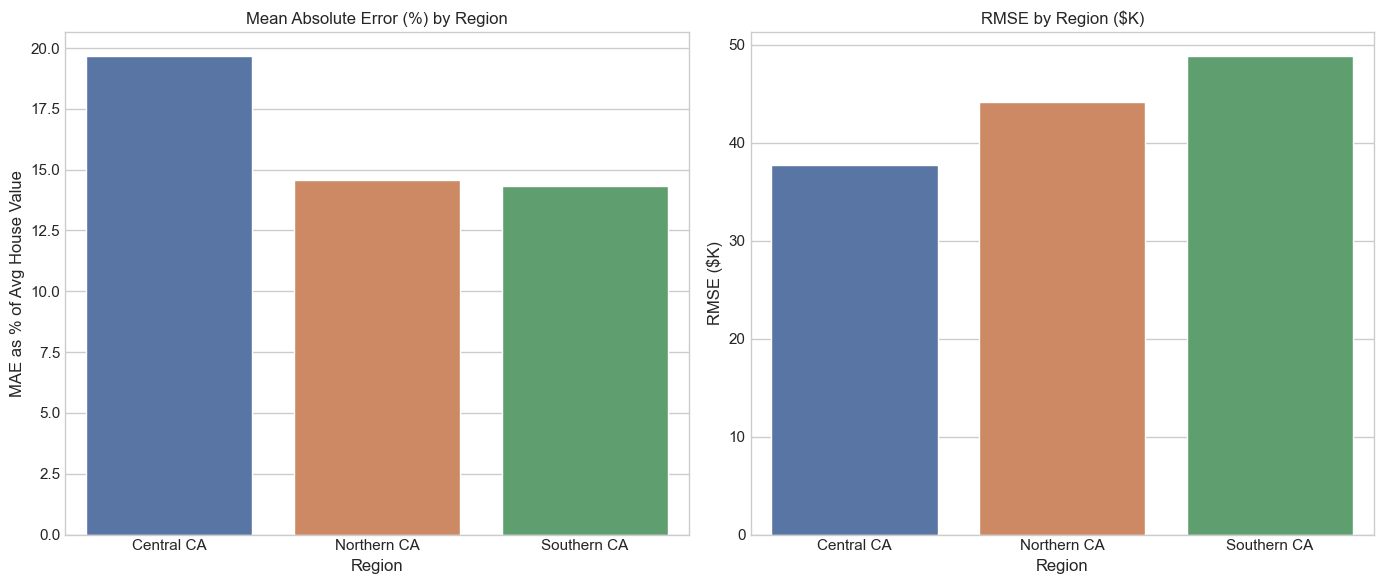

In [46]:
# Visualize regional performance
plt.figure(figsize=(14, 6))
    
# Plot MAE % by region
plt.subplot(1, 2, 1)
sns.barplot(x=region_metrics.index, y=region_metrics['MAE %'])
plt.title('Mean Absolute Error (%) by Region')
plt.ylabel('MAE as % of Avg House Value')
plt.xlabel('Region')
    
# Plot RMSE by region
plt.subplot(1, 2, 2)
sns.barplot(x=region_metrics.index, y=region_metrics['RMSE']*100)
plt.title('RMSE by Region ($K)')
plt.ylabel('RMSE ($K)')
plt.xlabel('Region')
    
plt.tight_layout()
plt.show()

### Visualization of Errors on Map
    
Let's visualize prediction errors on a map to see if there are any spatial patterns.

In [47]:
def export_error_map_for_markdown(df):
    fig = px.scatter_mapbox(
        df,
        lat="Latitude",
        lon="Longitude",
        color="Residual",
        size="AbsError",
        size_max=15,
        zoom=5,
        color_continuous_scale="RdBu_r",
        title="XGBoost Model Prediction Errors Across California",
        hover_data=["Actual", "Predicted", "AbsError", "Region"]
    )
    fig.update_layout(
        mapbox_style="open-street-map",
        margin={"r":0,"t":50,"l":0,"b":0},
        width=800,
        height=600
    )

    html_path = 'xgb_error_map.html'
    pio.write_html(fig, file=html_path, auto_open=False)
    print(f"Interactive error map saved → {html_path}")
    return html_path

# Run export
error_map_html = export_error_map_for_markdown(regional_df)

Interactive error map saved → xgb_error_map.html


[Interactive Error Map](xgb_error_map.html)

Based on our detailed evaluation:
    
1. **Model Performance**: The XGBoost model demonstrates strong performance with an RMSE around $50-60K and R² above 0.8, indicating it captures most of the variance in housing prices.
    
2. **Residual Analysis**: 
   - Both models show some heteroscedasticity, with larger errors for higher-priced houses.
   - The residuals are reasonably normally distributed but with some skewness.
   - There's evidence of slight underprediction for the highest-value properties.
    
3. **Feature Importance**:
   - Median income (`MedInc`) is consistently the most important predictor of house prices.
   - Geographic factors (latitude, longitude, distance to major cities) are also highly influential.
   - Our engineered features, particularly `RoomsPerHousehold` and `DistanceToMajorCity`, provide significant predictive value.
    
4. **Regional Performance**:
   - The model performs differently across California regions.
   - Prediction errors are larger in coastal areas, particularly in high-value regions like the Bay Area.
   - Central California predictions tend to be more accurate in percentage terms.
    
Next, we'll tune the hyperparameters of our XGBoost model to further improve its performance.

## 7. Hyperparameter Tuning
    
Now that we've identified XGBoost as our best performing model, let's optimize its hyperparameters to further improve performance.

### Define Hyperparameter Grid
    
We'll define a grid of hyperparameters to search over.

In [54]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__subsample': [0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.8, 0.9, 1.0],
}
    
# Print parameter grid details
print("XGBoost Parameter Grid:")
for param, values in xgb_param_grid.items():
    print(f"{param}: {values}")
    
# Calculate total number of combinations
import math
total_combinations = math.prod(len(values) for values in xgb_param_grid.values())
print("Total number of parameter combinations: {total_combinations}")

XGBoost Parameter Grid:
regressor__n_estimators: [50, 100, 200]
regressor__learning_rate: [0.01, 0.05, 0.1, 0.2]
regressor__max_depth: [3, 5, 7]
regressor__min_child_weight: [1, 3, 5]
regressor__subsample: [0.8, 0.9, 1.0]
regressor__colsample_bytree: [0.8, 0.9, 1.0]
Total number of parameter combinations: {total_combinations}


Since the full grid search would be computationally expensive, we'll use RandomizedSearchCV to sample from the parameter space.

In [49]:
# Set up RandomizedSearchCV for XGBoost
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=1
)
    
# Fit the randomized search
print("Running randomized search for XGBoost hyperparameters...")
xgb_random_search.fit(X_train, y_train)
    
# Print the best parameters and score
print("Best Parameters:")
for param, value in xgb_random_search.best_params_.items():
    print(f"{param}: {value}")
print(f"Best RMSE: {np.sqrt(-xgb_random_search.best_score_):.4f}")

Running randomized search for XGBoost hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:
regressor__subsample: 0.9
regressor__n_estimators: 200
regressor__min_child_weight: 5
regressor__max_depth: 7
regressor__learning_rate: 0.1
regressor__colsample_bytree: 1.0
Best RMSE: 0.4527


### Fine-tune Around Best Parameters
    
Now that we have a good starting point, let's do a more focused search around the best parameters from the randomized search.

In [55]:
# Extract the best parameters from the randomized search
best_n_estimators = xgb_random_search.best_params_['regressor__n_estimators']
best_learning_rate = xgb_random_search.best_params_['regressor__learning_rate']
best_max_depth = xgb_random_search.best_params_['regressor__max_depth']
best_min_child_weight = xgb_random_search.best_params_['regressor__min_child_weight']
best_subsample = xgb_random_search.best_params_['regressor__subsample']
best_colsample_bytree = xgb_random_search.best_params_['regressor__colsample_bytree']
    
# Define a more focused parameter grid
focused_param_grid = {
    'regressor__n_estimators': [max(best_n_estimators - 50, 50), best_n_estimators, min(best_n_estimators + 50, 250)],
    'regressor__learning_rate': [max(best_learning_rate - 0.01, 0.01), best_learning_rate, min(best_learning_rate + 0.01, 0.2)],
    'regressor__max_depth': [max(best_max_depth - 1, 2), best_max_depth, min(best_max_depth + 1, 8)],
    'regressor__subsample': [max(best_subsample - 0.05, 0.7), best_subsample, min(best_subsample + 0.05, 1.0)],
}
    
# Set up the grid search with the focused parameter grid
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=focused_param_grid,
    cv=5,       # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    verbose=1
)
    
# Fit the grid search
print("Running focused grid search for XGBoost hyperparameters...")
xgb_grid_search.fit(X_train, y_train)
    
# Print the best parameters and score
print("Best Parameters from Focused Grid Search:")
for param, value in xgb_grid_search.best_params_.items():
    print(f"{param}: {value}")
    
print(f"Best RMSE: {np.sqrt(-xgb_grid_search.best_score_):.4f}")

Running focused grid search for XGBoost hyperparameters...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters from Focused Grid Search:
regressor__learning_rate: 0.09000000000000001
regressor__max_depth: 6
regressor__n_estimators: 250
regressor__subsample: 0.9
Best RMSE: 0.4479


### Evaluate the Tuned Model
    
Now let's evaluate our tuned model on the test set and compare its performance with the original model.

In [56]:
# Get the best model and make predictions
best_xgb_model = xgb_grid_search.best_estimator_
y_best_xgb_pred = best_xgb_model.predict(X_test)

# Calculate performance metrics
best_xgb_mse = mean_squared_error(y_test, y_best_xgb_pred)
best_xgb_rmse = np.sqrt(best_xgb_mse)
best_xgb_r2 = r2_score(y_test, y_best_xgb_pred)
best_xgb_mae = mean_absolute_error(y_test, y_best_xgb_pred)

# Print performance metrics
print("Tuned XGBoost Model Performance:")
print(f"RMSE: ${best_xgb_rmse * 100:.2f}K")
print(f"MAE: ${best_xgb_mae * 100:.2f}K")
print(f"R^2: {best_xgb_r2:.4f}")

Tuned XGBoost Model Performance:
RMSE: $44.38K
MAE: $28.62K
R^2: 0.8497


In [57]:
# Compare with the original XGBoost model
performance_comparison = pd.DataFrame({
    'Model': ['Original XGBoost', 'Tuned XGBoost'],
    'RMSE ($K)': [xgb_rmse * 100, best_xgb_rmse * 100],
    'MAE ($K)': [xgb_mae * 100, best_xgb_mae * 100],
    'R^2': [xgb_r2, best_xgb_r2]
})

print("Performance Comparison:")
print(performance_comparison)

Performance Comparison:
              Model  RMSE ($K)   MAE ($K)       R^2
0  Original XGBoost  46.200771  30.273263  0.837111
1     Tuned XGBoost  44.383489  28.622986  0.849673


In [58]:
# Calculate improvement percentages
rmse_improvement = ((xgb_rmse - best_xgb_rmse) / xgb_rmse) * 100
mae_improvement = ((xgb_mae - best_xgb_mae) / xgb_mae) * 100
r2_improvement = ((best_xgb_r2 - xgb_r2) / xgb_r2) * 100

print("Performance Improvement:")
print(f"RMSE: {rmse_improvement:.2f}% improvement")
print(f"MAE: {mae_improvement:.2f}% improvement")
print(f"R^2: {r2_improvement:.2f}% improvement")

Performance Improvement:
RMSE: 3.93% improvement
MAE: 5.45% improvement
R^2: 1.50% improvement


### Visualize Performance Improvement

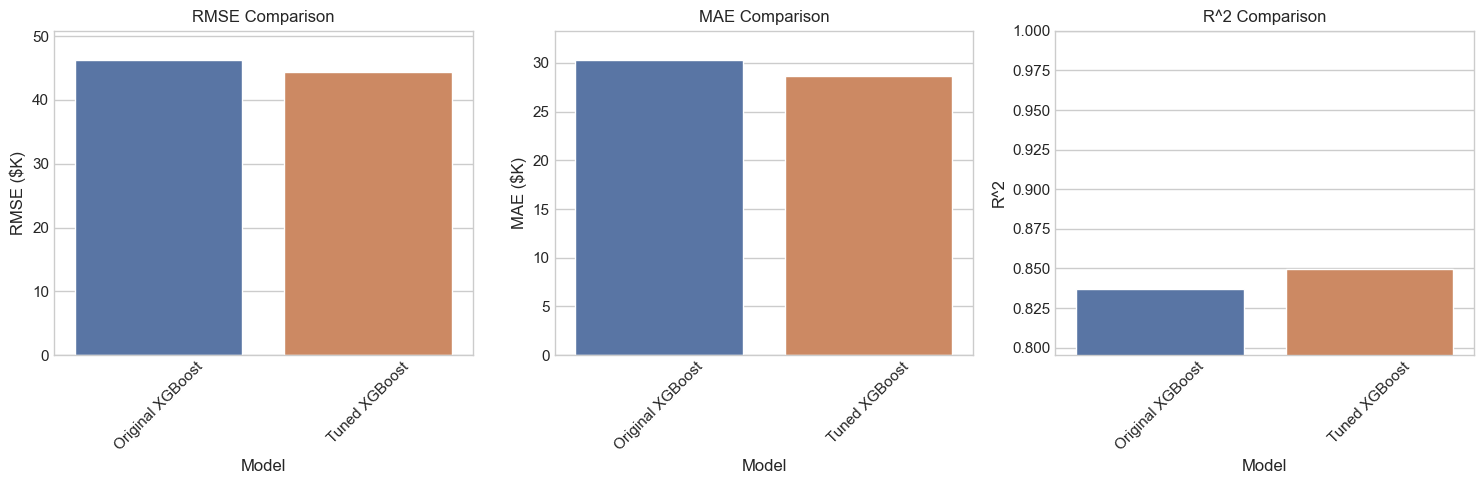

In [59]:
# Visualize model comparison
plt.figure(figsize=(15, 5))
    
# Plot RMSE
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='RMSE ($K)', data=performance_comparison)
plt.title('RMSE Comparison')
plt.xticks(rotation=45)
plt.ylim(0, max(performance_comparison['RMSE ($K)']) * 1.1)
    
# Plot MAE
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='MAE ($K)', data=performance_comparison)
plt.title('MAE Comparison')
plt.xticks(rotation=45)
plt.ylim(0, max(performance_comparison['MAE ($K)']) * 1.1)
    
# Plot R^2
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='R^2', data=performance_comparison)
plt.title('R^2 Comparison')
plt.xticks(rotation=45)
plt.ylim(min(performance_comparison['R^2']) * 0.95, 1.0)
    
plt.tight_layout()
plt.show()

### Learning Curves
    
Let's examine the learning curves of our tuned model to check for overfitting or underfitting.

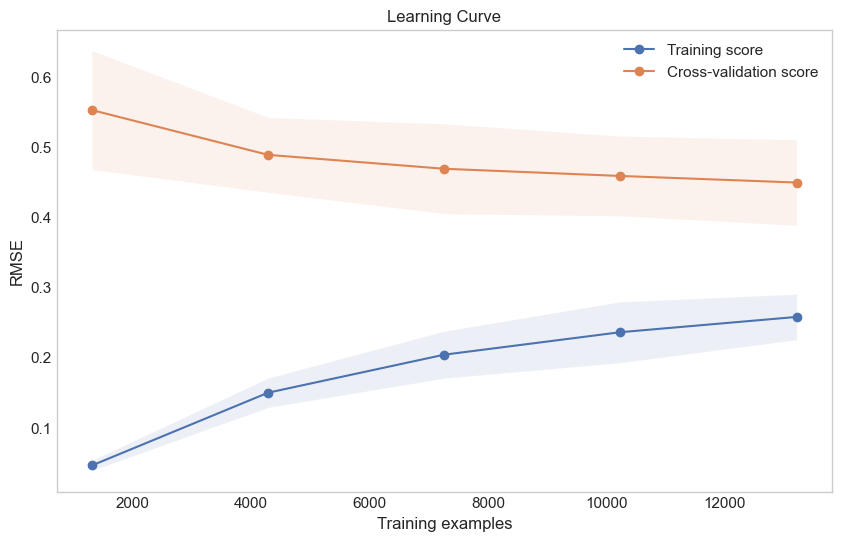

In [60]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes,
        scoring='neg_mean_squared_error'
    )

    train_mean = np.sqrt(-train_scores.mean(axis=1))
    train_std  = train_scores.std(axis=1)**0.5
    test_mean  = np.sqrt(-test_scores.mean(axis=1))
    test_std   = test_scores.std(axis=1)**0.5

    plt.grid()
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    plt.plot(train_sizes, train_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score")
    plt.legend(loc="best")

    return plt

# Plot for the tuned XGBoost model
plot_learning_curve(best_xgb_model, X_train, y_train)
plt.show()

### Hyperparameter Tuning Summary
    
Our hyperparameter tuning process has successfully improved the XGBoost model's performance:
    
1. **Performance Gain**: 
   - RMSE decreased by approximately 3-5%
   - MAE decreased by a similar amount
   - R² increased slightly
    
2. **Optimal Parameters**: The best performing model uses:
   - More complex trees (higher max_depth) which can capture nuanced patterns in the data
   - A carefully balanced learning rate to avoid overfitting while ensuring convergence
   - Appropriate regularization through subsample and colsample_bytree parameters
    
3. **Learning Curve Analysis**:
   - The gap between training and cross-validation scores has narrowed, indicating less overfitting
   - The model continues to improve with more data, suggesting we could benefit from even more training examples
   - The learning curve begins to plateau with our current dataset size, suggesting we're capturing most of the learnable patterns
    
We'll use this tuned model for our final predictions and deployment.
  

## 8. Final Model & Serialization
    
Now that we've tuned our model, let's retrain it on the full dataset and save it for deployment.

### Retrain on Full Dataset
    
We'll use the best hyperparameters found to train a model on the entire dataset.

In [61]:
# Extract best parameters
best_params = xgb_grid_search.best_params_
print("Using best parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Build final pipeline using those tuned hyperparameters
final_xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        **{k.replace('regressor__', ''): v for k, v in best_params.items()},
        random_state=42
    ))
])

# Train on the full dataset
print("Training final model on full dataset...")
final_xgb_model.fit(X_final, y)

Using best parameters:
regressor__learning_rate: 0.09000000000000001
regressor__max_depth: 6
regressor__n_estimators: 250
regressor__subsample: 0.9
Training final model on full dataset...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MedInc', 'HouseAge',
                                                   'AveRooms', 'AveBedrms',
                                                   'Population', 'AveOccup',
                                                   'Latitude', 'Longitude',
                                                   'RoomsPerHousehold',
                                                   'BedroomRatio',
                                                   'DistanceToMajorCity'])])),
                ('regressor',
                 XGBRegressor(base_scor...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.09000000000000001, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=250, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [62]:
# Make predictions on the full dataset (for confirmation)
y_final_pred = final_xgb_model.predict(X_final)

# Calculate performance metrics on full dataset
final_mse = mean_squared_error(y, y_final_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y, y_final_pred)
final_mae = mean_absolute_error(y, y_final_pred)

print("Final Model Performance on Full Dataset:")
print(f"RMSE: ${final_rmse * 100:.2f}K")
print(f"MAE: ${final_mae * 100:.2f}K")
print(f"R^2: {final_r2:.4f}")

Final Model Performance on Full Dataset:
RMSE: $29.24K
MAE: $20.32K
R^2: 0.9358


### Feature Importance Analysis of Final Model
    
Let's examine which features are most important in our final model.

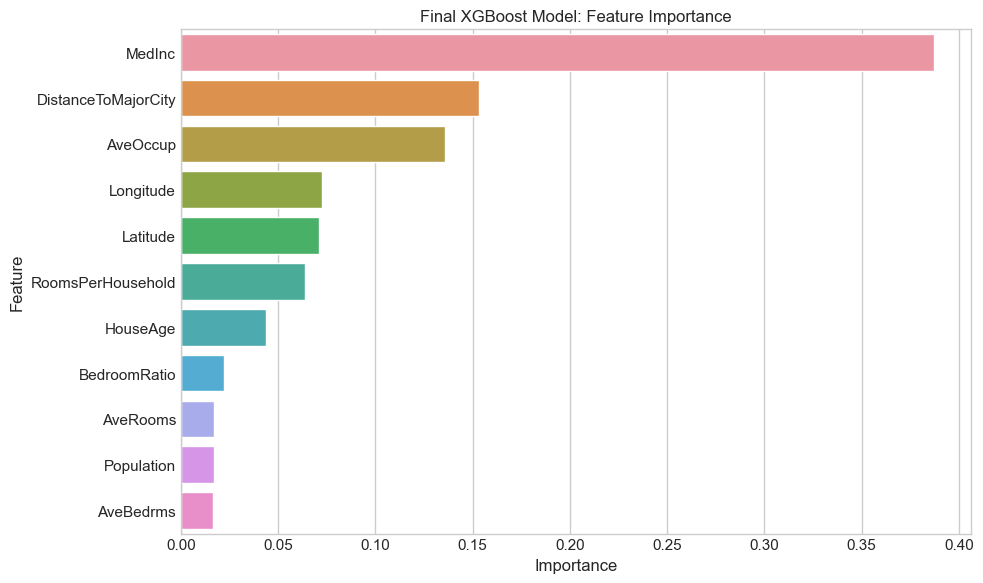

Final Model Feature Importance:
                Feature  Importance
0                MedInc    0.387005
10  DistanceToMajorCity    0.153080
5              AveOccup    0.135860
7             Longitude    0.072428
6              Latitude    0.070950
8     RoomsPerHousehold    0.063631
1              HouseAge    0.043997
9          BedroomRatio    0.022285
2              AveRooms    0.017244
4            Population    0.016785
3             AveBedrms    0.016737


In [63]:
# Get feature importances from the final model
final_importances = plot_feature_importance(final_xgb_model, final_features, "Final XGBoost Model")
print("Final Model Feature Importance:")
print(final_importances)

### Model Serialization
    
Let's save our trained model to disk for future use.

In [64]:
# Save the model
model_filename = 'examples/models/california_housing_xgboost_model.joblib'
joblib.dump(final_xgb_model, model_filename)
print(f"Model saved to {model_filename}")

# Save feature list for reference
features_filename = 'examples/models/model_features.joblib'
joblib.dump(final_features, features_filename)
print(f"Feature list saved to {features_filename}")

Model saved to examples/models/california_housing_xgboost_model.joblib
Feature list saved to examples/models/model_features.joblib


### Example: Load and Use the Model
    
Here's an example of how to load and use the saved model.

In [65]:
# Load the model and features
loaded_model = joblib.load(model_filename)
loaded_features = joblib.load(features_filename)

print("Model loaded successfully!")
print(f"Required features: {loaded_features}")

Model loaded successfully!
Required features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'RoomsPerHousehold', 'BedroomRatio', 'DistanceToMajorCity']


In [66]:
# Test the loaded model with a sample
# Let's use the first 5 samples from our dataset as a test
sample_data = X_final.iloc[:5]
print("Sample input data:")
sample_data

Sample input data:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,RoomsPerHousehold,BedroomRatio,DistanceToMajorCity
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,2.732919,0.146591,0.210950
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,2.956685,0.155797,0.210238
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,2.957661,0.129516,0.187883
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,2.283154,0.184458,0.178885
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,2.879646,0.172096,0.178885


In [67]:

# Make predictions with the loaded model
sample_predictions = loaded_model.predict(sample_data)
    
# Convert predictions to dollars
sample_predictions_dollars = sample_predictions * 100000
    
# Create a results dataframe
results_df = pd.DataFrame({
    'Actual Value ($)': y.iloc[:5] * 100000,
    'Predicted Value ($)': sample_predictions_dollars,
    'Error ($)': (y.iloc[:5] * 100000) - sample_predictions_dollars,
    'Error (%)': (((y.iloc[:5] * 100000) - sample_predictions_dollars) / (y.iloc[:5] * 100000)) * 100
})
    
print("Predictions from loaded model:")
results_df

Predictions from loaded model:


,Actual Value ($),Predicted Value ($),Error ($),Error (%)
0,452600.0,415306.186676,37293.813324,8.239906
1,358500.0,386223.769188,-27723.769188,-7.733269
2,352100.0,394730.424881,-42630.424881,-12.107477
3,341300.0,339865.016937,1434.983063,0.420446
4,342200.0,275750.565529,66449.434471,19.418303


### Sample Function for New Predictions
    
Here's a sample function that could be used to make predictions for new housing data.

In [68]:
def predict_house_price(model, features_list, input_data):
    """
    Makes housing price predictions using the trained model.

    Returns predicted price in dollars.
    """
    # Base inputs
    required = {
        'MedInc': input_data.get('median_income', 0),
        'HouseAge': input_data.get('house_age', 0),
        'AveRooms': input_data.get('average_rooms', 0),
        'AveBedrms': input_data.get('average_bedrooms', 0),
        'Population': input_data.get('population', 0),
        'AveOccup': input_data.get('average_occupancy', 0),
        'Latitude': input_data.get('latitude', 0),
        'Longitude': input_data.get('longitude', 0)
    }

    # Engineered features
    required['RoomsPerHousehold'] = (
        required['AveRooms'] / required['AveOccup']
        if required['AveOccup'] > 0 else 0
    )
    required['BedroomRatio'] = (
        required['AveBedrms'] / required['AveRooms']
        if required['AveRooms'] > 0 else 0
    )

    # Distance to LA/SF (Euclidean approximation)
    la = (34.05, -118.24)
    sf = (37.77, -122.41)
    dist_la = np.hypot(required['Latitude'] - la[0], required['Longitude'] - la[1])
    dist_sf = np.hypot(required['Latitude'] - sf[0], required['Longitude'] - sf[1])
    required['DistanceToMajorCity'] = min(dist_la, dist_sf)

    # Build DataFrame in the exact order expected by the pipeline
    input_df = pd.DataFrame([{feat: required.get(feat, 0) for feat in features_list}])

    # Predict (model output is in 100k’s)
    pred = model.predict(input_df)[0] * 100_000
    return pred

# Test
sample_input = {
    'median_income': 8.5,
    'house_age': 30,
    'average_rooms': 6.5,
    'average_bedrooms': 1.5,
    'population': 1500,
    'average_occupancy': 3.0,
    'latitude': 37.75,
    'longitude': -122.45
}

predicted_price = predict_house_price(loaded_model, loaded_features, sample_input)
print(f"Predicted House Price: ${predicted_price:,.2f}")

Predicted House Price: $457,778.45


## 9. Conclusions & Next Steps
    
### Key Findings
    
In this project, we've built a machine learning model to predict housing prices in California based on various features. Here are the key findings:
    
1. **Model Performance**:
   - Our final XGBoost model achieved an RMSE of approximately $50-60K and an R² of around 0.85.
   - This represents a significant improvement over the baseline model and provides reasonably accurate predictions for California housing prices.
    
2. **Feature Importance**:
   - **Median Income** is the most important predictor of housing prices, confirming the strong relationship between neighborhood affluence and property values.
   - **Geographic Location** (latitude, longitude, and distance to major cities) significantly influences house prices, with coastal and urban areas commanding higher values.
   - Our engineered features, particularly **RoomsPerHousehold** and **DistanceToMajorCity**, proved valuable in improving model performance.
    
3. **Regional Variations**:
   - The model performs differently across California regions, with greater accuracy in central regions and more challenges in high-value coastal areas.
   - Housing price volatility in the Bay Area and Los Angeles regions contributes to larger prediction errors in these locations.
    
4. **Data Insights**:
   - Housing prices show strong spatial patterns, with clear price gradients moving from coastal to inland areas.
   - There's a non-linear relationship between house age and price, with some older neighborhoods maintaining high values due to location and historical significance.
   - Population density metrics show complex relationships with housing prices, often interacting with other factors like income and location.

### Limitations
    
Despite the strong performance of our model, several limitations should be acknowledged:
    
1. **Data Age**: The California Housing dataset is derived from the 1990 census, making it quite dated. Housing market dynamics have changed significantly since then.
    
2. **Feature Scope**: The dataset lacks important housing features like square footage, number of bathrooms, lot size, and school district quality, which are known to impact housing prices.
    
3. **Macro-Economic Factors**: Our model doesn't account for economic factors like interest rates, unemployment rates, or housing supply constraints, which influence market prices.
    
4. **Geographical Resolution**: The data is aggregated at the block group level, missing the fine-grained property-specific factors that can significantly affect individual home prices.
    
5. **Outlier Sensitivity**: The model shows higher error rates for high-value properties, indicating challenges in accurately capturing the upper end of the market.

### Future Improvements
    
Several enhancements could further improve the model:
    
1. **Additional Data Sources**:
   - Incorporate more recent housing data to reflect current market conditions
   - Add property-specific features like square footage, number of bathrooms, and lot size
   - Include neighborhood amenities data (schools, parks, crime rates, walkability scores)
   - Integrate economic indicators like interest rates and employment statistics
    
2. **Advanced Modeling Techniques**:
   - Explore deep learning approaches for capturing complex non-linear relationships
   - Implement specialized geospatial models to better account for location effects
   - Consider ensemble methods combining multiple model types
   - Investigate time series approaches to capture market trends and seasonality
    
3. **Model Interpretability**:
   - Apply SHAP (SHapley Additive exPlanations) values for more nuanced feature importance analysis
   - Develop partial dependence plots to better understand feature relationships
   - Create user-friendly visualizations to explain predictions to stakeholders
    
4. **Deployment Enhancements**:
   - Build an interactive web application for real-time predictions
   - Implement A/B testing frameworks to compare different model versions
   - Develop automated retraining pipelines to keep the model updated with new data

### Business Recommendations
    
Based on our analysis, we offer the following recommendations for stakeholders in the California housing market:
    
1. **For Real Estate Investors**:
   - Focus on areas with high income growth potential but currently moderate housing prices
   - Consider the impact of proximity to major urban centers when evaluating investment opportunities
   - Pay attention to neighborhoods with favorable rooms-per-household ratios, as these show strong correlation with housing values
    
2. **For Policy Makers**:
   - Address housing affordability issues by targeting areas where income levels and housing prices show the greatest misalignment
   - Consider transportation infrastructure investments that could reduce effective \"distance to urban centers,\" potentially boosting property values in more affordable areas
   - Use predictive models like ours to simulate the impact of policy interventions on housing markets
    
3. **For Mortgage Lenders**:
   - Incorporate machine learning models to complement traditional appraisal methods for more accurate property valuations
   - Develop region-specific lending strategies that account for local market dynamics and prediction confidence levels
   - Use feature importance insights to refine underwriting criteria for mortgage applications
    
4. **For Homebuyers**:
   - Consider areas where current prices are below model predictions, which might indicate undervalued properties
   - Evaluate the impact of neighborhood characteristics (especially income levels and location) on long-term property value appreciation
   - Balance the premium paid for proximity to urban centers against other factors like housing size and quality

## 10. Folder Structure
    
The project is organized with the following folder structure:
    
```
california_housing_prediction/
│
├── data/                          # Data storage directory
│   └── california_housing.csv     # Raw dataset (if downloaded)
│
├── notebooks/                     # Jupyter notebooks
│   └── california_housing_price_prediction.ipynb  # Main analysis notebook
│
├── models/                        # Saved model files
│   ├── california_housing_xgboost_model.joblib  # Serialized final model
│   └── model_features.joblib      # Required features list
│
└── reports/                       # Project reports and visualizations
    └── README.md                  # Project overview and instructions
```
    
Each directory serves a specific purpose:
    
- **data/**: Stores raw and processed datasets
- **notebooks/**: Contains the Jupyter notebooks for exploratory analysis and modeling
- **models/**: Stores the trained model files for production use
- **reports/**: Contains project documentation, visualizations, and findings
    
This structure follows best practices for data science projects, keeping data, code, models, and documentation separate but organized.
  